# Hands-on 1: OFDM Basics (ortogonalidade, transmissão e recepção, desempenho em canal sem fio)
* Aluno: Lucas Ismael Campos Medeiros

## Entrega 01: loopback OFDM em canais AWGN
Faça um loopback de transmissão e recepção OFDM em Python (ou Matlab) com as seguintes mudanças:
   1. Eb/N0 como variável de entrada. Variar a Eb/N0 de 0 a 14 dB e calcular a variância do ruído, considerando as modulações BPSK e 16-QAM;
   2. Usar as funções ifft e fft para multiplexar (TX) e demultiplexar (RX);
   3. Fazer o gráfico da BER vs Eb/N0 para com OFDM e, no mesmo gráfico, o gráfico da probabilidade de erro teórica vs Eb/N0 das modulações BPSK e 16-QAM com e sem OFDM.
    

## Fórmulas importantes:

**1. Função Q:**
    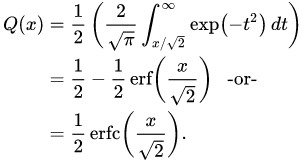
**2. Probabilidades de erro de bit teórico:**
    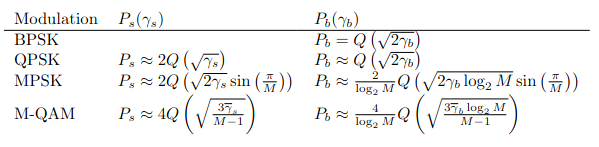


## Implementação do código:

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft
from scipy import special as sp
import commpy
import cmath

def qfunc(x):
    return 0.5-0.5*sp.erf(x/np.sqrt(2))

snrdb = np.arange(0,15)

n_size = 200000
M = [16]
txmsg = np.random.randint(0,2,size=n_size)
for M in M:
    BER_QAM = []
    BER_QAM_TEO = []
    BER_BPSK = []
    BER_BPSK_TEO = []
    qam = commpy.QAMModem(M)
    bpsk = commpy.PSKModem(2)
    sinalqam = qam.modulate(txmsg)
    sinalbpsk = bpsk.modulate(txmsg)
    sinalqam = sinalqam[:,None]
    sinalbpsk = sinalbpsk[:,None]
    sinaltxqam = ifft(sinalqam)
    sinaltxbpsk = ifft(sinalbpsk)
    
    for i in snrdb:
        BER_QAM_MC = []
        BER_BPSK_MC = []
        EbN0 = 10**(i/10)
        N0qam = commpy.utilities.signal_power(sinaltxqam)*10**(-i/10)
        N0bpsk = commpy.utilities.signal_power(sinaltxbpsk)*10**(-i/10)
        for k in range(0,10):
            noiseqam = np.sqrt(N0qam/2)*np.random.randn(np.shape(sinaltxqam)[0],1)+1j*np.sqrt(N0qam/2)*np.random.randn(np.shape(sinaltxqam)[0],1)
            noisebpsk = np.sqrt(N0bpsk/2)*np.random.randn(np.shape(sinaltxbpsk)[0],1)+1j*np.sqrt(N0bpsk/2)*np.random.randn(np.shape(sinaltxbpsk)[0],1)
            signoiseqam = sinaltxqam + noiseqam
            signoisebpsk = sinaltxbpsk + noisebpsk
            
            sinalrxqam = fft(signoiseqam)
            sinalrxbpsk = fft(signoisebpsk)
            indexlistqam = np.abs(sinalrxqam[:,:] - qam.constellation).argmin(axis=1)
            indexlistbpsk = np.abs(sinalrxbpsk[:,:] - bpsk.constellation).argmin(axis=1)
            demodsignalqam = []
            demodsignalbpsk = []
            for symbolq in indexlistqam:
                demodsignalqam.extend(commpy.utilities.decimal2bitarray(symbolq,qam.num_bits_symbol))
            for symbolb in indexlistbpsk:
                demodsignalbpsk.extend(commpy.utilities.decimal2bitarray(symbolb,bpsk.num_bits_symbol))
            nErrorsqam = sum(txmsg ^ demodsignalqam)
            nErrorsbpsk = sum(txmsg ^demodsignalbpsk)
            BER_QAM_MC = np.append(BER_QAM_MC, nErrorsqam/(n_size))
            BER_BPSK_MC = np.append(BER_BPSK_MC, nErrorsbpsk/(n_size))
        BER_QAM_TEO = np.append(BER_QAM_TEO, (4/np.log2(M))*(1-1/np.sqrt(M))*np.asanyarray(qfunc(np.sqrt(3*(4/np.log2(M))*EbN0/(M-1)))))
        BER_BPSK_TEO = np.append(BER_BPSK_TEO, qfunc(np.sqrt(2*10**(i/10))))
        BER_QAM = np.append(BER_QAM, np.mean(BER_QAM_MC))
        BER_BPSK = np.append(BER_BPSK, np.mean(BER_BPSK_MC))

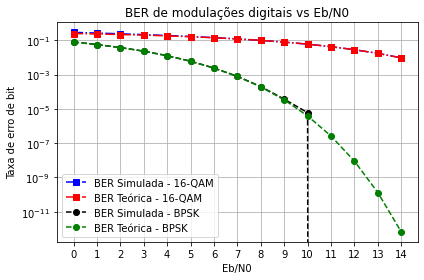

In [14]:
plt.figure()
plt.semilogy(snrdb, BER_QAM, "bs-.", label="BER Simulada - "+ str(M)+"-QAM")
plt.semilogy(snrdb, BER_QAM_TEO, "rs-.", label="BER Teórica - "+str(M)+"-QAM")
plt.semilogy(snrdb, BER_BPSK, "ko--", label="BER Simulada - BPSK")
plt.semilogy(snrdb, BER_BPSK_TEO, "go--", label="BER Teórica - BPSK")
plt.title("BER de modulações digitais vs Eb/N0")
plt.ylabel("Taxa de erro de bit")
plt.xlabel("Eb/N0")
plt.xticks(snrdb)
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

------------